In [1]:
# --- Bevezetés: Könyvtárak importálása
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from dotenv import load_dotenv
import os
import sys
from azure.storage.blob import BlobServiceClient
import io

sys.path.insert(0, os.path.abspath('..'))
load_dotenv()

AZURE_CONNECTION_STRING = os.getenv("AZURE_CONNECTION_STRING")
AZURE_CONTAINER_NAME = "courtrankrl"
BLOB_PATH = "processed/documents_with_embeddings.parquet"

# Adatok letöltése és beolvasása a Blob Storage-ból
print(f"Adatok letöltése: {AZURE_CONTAINER_NAME}/{BLOB_PATH}...")
try:
    blob_service_client = BlobServiceClient.from_connection_string(AZURE_CONNECTION_STRING)
    blob_client = blob_service_client.get_blob_client(container=AZURE_CONTAINER_NAME, blob=BLOB_PATH)
    stream_downloader = blob_client.download_blob()
    print("Adatok letöltve sikeresen.")
except Exception as e:
    print(f"Hiba történt a Blob Storage-ból való letöltés során: {e}")
    sys.exit(1)




Adatok letöltése: courtrankrl/processed/documents_with_embeddings.parquet...
Adatok letöltve sikeresen.


Betöltött dokumentumok száma: 829337
Első embedding típusa: <class 'numpy.ndarray'>
Első embedding dimenziója: 768
Hiányzó embeddingek száma: 0
PCA első két komponens varianciája: [0.09547024 0.07522239]


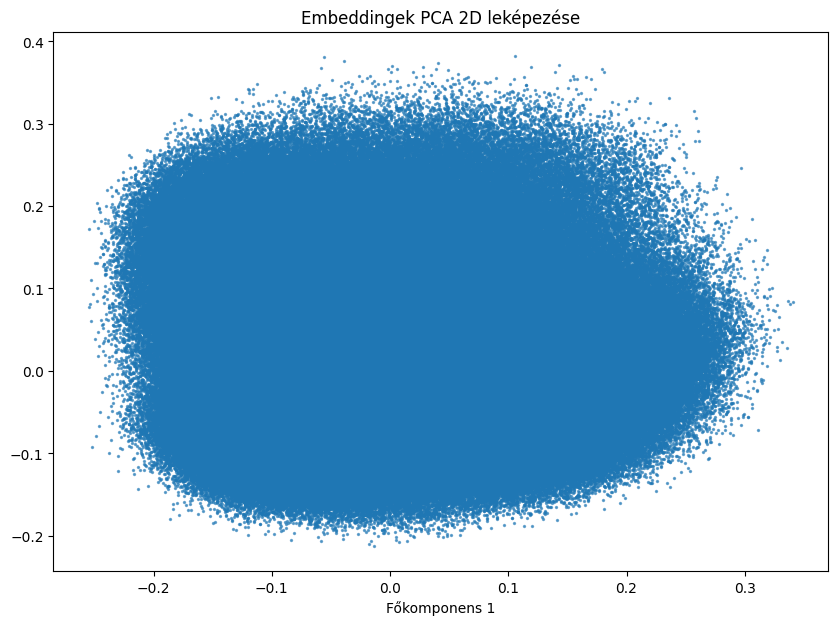

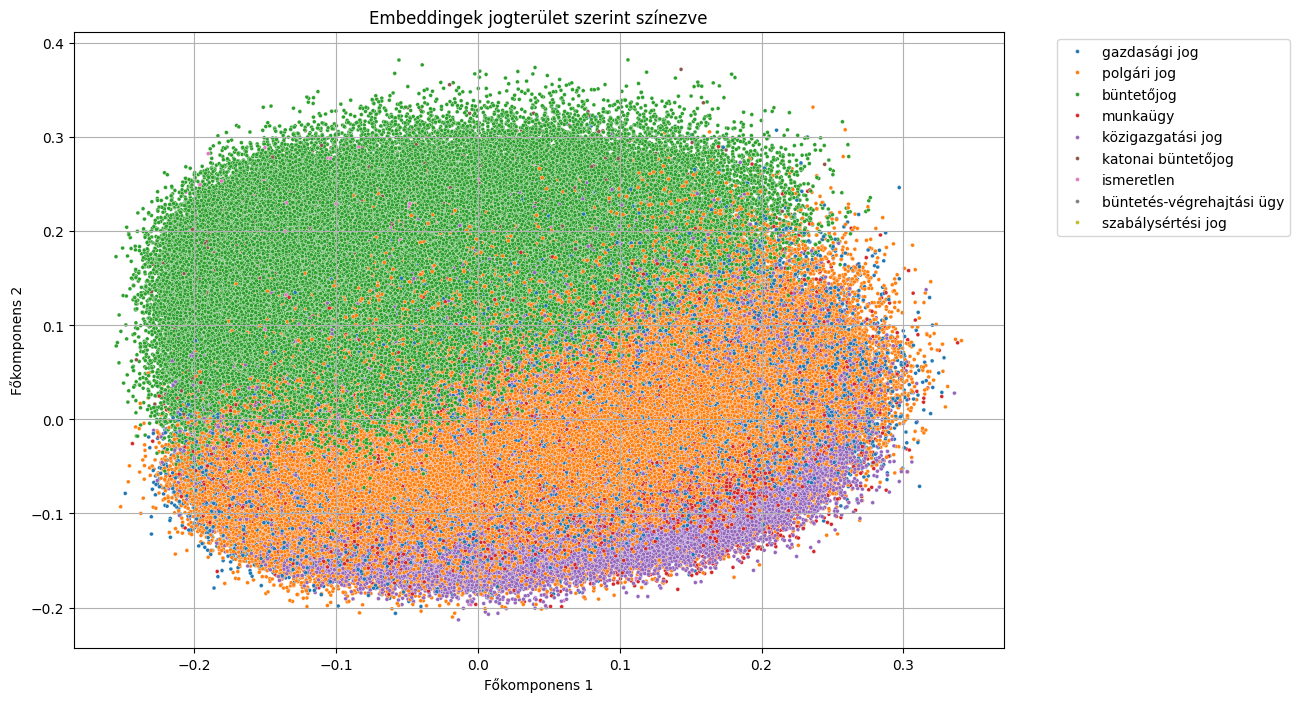

EDA lépések befejezve. Ellenőrizd az ábrákat és a szóródást.


In [2]:
# --- 1. Lépés: Embeddingek betöltése
from configs import config

# Betöltés
embedding_df = pd.read_parquet(io.BytesIO(stream_downloader.readall()))
print(f"Betöltött dokumentumok száma: {len(embedding_df)}")

# --- 2. Lépés: Embeddingek alapellenőrzése

# Ellenőrizzük az embeddingek típusát és dimenzióját
print(f"Első embedding típusa: {type(embedding_df['embedding'].iloc[0])}")
print(f"Első embedding dimenziója: {len(embedding_df['embedding'].iloc[0])}")

# Hiányzó embeddingek számának ellenőrzése
missing_embeddings = embedding_df['embedding'].isna().sum()
print(f"Hiányzó embeddingek száma: {missing_embeddings}")

# --- 3. Lépés: PCA dimenziócsökkentés

# Embeddingek NumPy tömbbé alakítása
# Először távolítsuk el a hiányzó embeddingeket tartalmazó sorokat a DataFrame-ből
valid_embeddings_df = embedding_df.dropna(subset=['embedding'])
# Majd alakítsuk a Series-t listává a vstack számára
X = np.vstack(valid_embeddings_df['embedding'].tolist())


# PCA futtatása
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print(f"PCA első két komponens varianciája: {pca.explained_variance_ratio_}")

# --- 4. Lépés: PCA eredmény vizualizáció

plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=2, alpha=0.6)
plt.title("Embeddingek PCA 2D leképezése")
plt.xlabel("Főkomponens 1")
# --- 5. Lépés (opcionális): Jogterületi színezés, ha van ilyen mező

if 'JogTerulet' in embedding_df.columns:
    # Használjuk a már szűrt DataFrame-et, hogy a címkék száma megegyezzen a redukált pontok számával
    jogterulet_labels = valid_embeddings_df['JogTerulet'].fillna('ismeretlen').values

    plt.figure(figsize=(12,8))
    sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=jogterulet_labels, s=8, palette='tab10')
    plt.title("Embeddingek jogterület szerint színezve")
    plt.xlabel("Főkomponens 1")
    plt.ylabel("Főkomponens 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()
else:
    print("Jogterület mező nem található a DataFrame-ben.")

# --- Vége: Kiértékelés

print("EDA lépések befejezve. Ellenőrizd az ábrákat és a szóródást.")
